In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

from v1sh_model.inputs.visualize import visualize_input, visualize_output
from v1sh_model.models.V1_model_1 import V1_model_1 as V1_model
from v1sh_model.inputs.examples import bar_without_surround

In [ ]:
# Instantiate and test the FullModel
seed = 42
model = V1_model(seed=seed, alpha_x=1.0, alpha_y=1.0)
T = 12 
dt = 0.01

# 1. Leaking out in length or width

In [ ]:
def half_infinitly_line(N_x = 4, N_y = 2, I_input = 1.5):
    A = np.full((N_y, N_x), np.pi / 2)
    C = np.zeros((N_y, N_x))
    C[int(N_y / 2), int(N_x / 2):] = I_input
    return A, C

In [ ]:
N_y = 100
N_x = 400
A, C = half_infinitly_line(N_x=N_x, N_y=N_y, I_input=1.5)
visualize_input(A, C, dpi = 300)
plt.show()

X_gen, Y_gen, I = model.simulate(A, C, dt=dt, T=T, verbose=False, noisy=False, mode="wrap")

In [ ]:
model_output = model.g_x(X_gen.mean(axis=0)) # N_y x N_x x K
C_out = model_output # .max(axis=-1)  # N_y x N_x
argmax_angle_indices = model_output.argmax(axis=-1)  # N_y x N_x
A_out = np.broadcast_to(model.M, (N_y, N_x, model.K))
visualize_output(A_out[49:-49, 195:-180], C_out[49:-49, 195:-180] * 1.1, verbose=False, dpi = 500)
plt.show()

Observation:
- no leaking out for low inputs (1.5) and averaging x(t) over time first, then taking g_x; as analyzed and in Fig. 5.61.B
-> do I see activation of neurons in same hypercolumn though?
- leaking out in length and width for higher input and averaging after taking g_x

# 2. Filling in

Next to 
a) colinear facilitation = filling-in gaps of a line through excitation of neighboring neurons
also 
b) non-conspicious gaps due to dominating iso-orientation supression in iso-oriented textures

Show b) here..

In [ ]:
def texture_with_gaps(N_x = 4, N_y = 2, I_input = 1.05, gap_prob = 0.1, seed = None):
    A = np.full((N_y, N_x), np.pi / 4)
    rng = np.random.default_rng(seed)
    C = rng.binomial(1, 1 - gap_prob, size = (N_y, N_x)) * I_input
    return A, C

A_text, C_text = texture_with_gaps(N_x=21, N_y=21, I_input=2.5, gap_prob=0.05, seed=43)

In [ ]:
X_gen_fill, _, _ = model.simulate(A_text, C_text, dt=dt, T=T, verbose=False, noisy=False, mode="wrap")

In [ ]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, dpi=300, figsize=(10, 5))

visualize_input(A_text, C_text, scale = 1, dpi = 400, axis = axes[0], verbose=False)
axes[0].set_title(r"Visual input $\hat{I}_{i\theta}$", fontsize=14)

model_output = model.g_x(X_gen_fill).mean(axis=0) # N_y x N_x x K
C_out = model_output.max(axis=-1)  # N_y x N_x
argmax_angle_indices = model_output.argmax(axis=-1)  # N_y x N_x
A_out = argmax_angle_indices  * np.pi / model.K # np.broadcast_to(model.M, (20, 20, model.K))
visualize_output(A_out, C_out, scale = 0.15, axis = axes[1], verbose=False)
axes[1].set_title(r"Model output $g_x(x_{i\theta})$", fontsize=14)

plt.show()

Observation:
- small but existing values in gaps for mean after g_x
- but no output (for the same input value as in the previous figure) else
- maybe different input contrast than in original paper

# 3. Dynamics

*c.f. Fig. 10 in "Computational Design and Nonlinear Dynamics of a Recurrent Network Model of the Primary Visual Cortex", Zhaoping 2001*

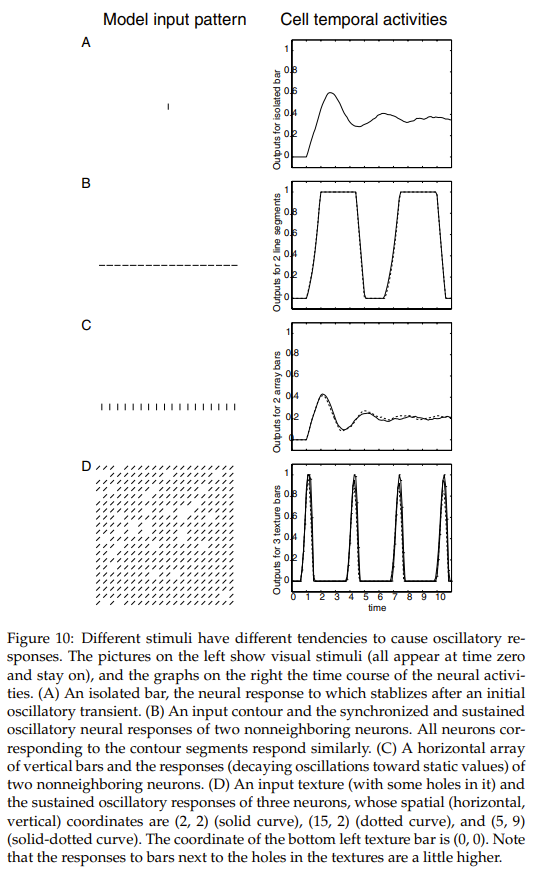

In [ ]:
def plot_neuron_dynamics(g_X, neurons_to_plot, title, dpi=300, axis=None, show_legend = False):
    t = np.arange(0, g_X.shape[0] * dt, dt)
    if axis is None:
        fig, axis = plt.subplots(constrained_layout=True, dpi=dpi)
        axis.set_xlabel("Time")
    linestyles = ['-', '--', '-.', ':']
    for index, (i, j) in enumerate(neurons_to_plot):
        axis.plot(t, g_X[:, i, j].max(axis=-1), label=f"({i}, {j})", linestyle = linestyles[index],
                linewidth = 3)
    axis.set_ylabel("Outputs for " + title)
    axis.set_ylim(-0.1, 1.1)
    axis.set_xlim(0, T-1)
    if len(neurons_to_plot) > 1 and show_legend:
        axis.legend(title="Neuron", loc="lower right")
    return axis

In [ ]:
def horizontal_line(N_x = 9, N_y = 9, I_input = 1.5, angle = np.pi / 2):
    A = np.full((N_y, N_x), angle)
    C = np.zeros((N_y, N_x))
    C[int(N_y / 2), :] = I_input
    return A, C

In [ ]:
A_bar, C_bar = bar_without_surround(N_x=61, N_y=61, I_input = 1.5)
X_bar, _, _ = model.simulate(A_bar, C_bar, dt=dt, T=T, noisy=True, mode="wrap")

A_hl, C_hl = horizontal_line(N_x=61, N_y=61, I_input=1.5, angle=np.pi / 2)
X_hl, _, _ = model.simulate(A_hl, C_hl, dt=dt, T=T, noisy=True, mode="wrap")

A_vl, C_vl = horizontal_line(N_x=61, N_y=61, I_input=1.5, angle=0.)
X_vl, _, _ = model.simulate(A_vl, C_vl, dt=dt, T=T, noisy=True, mode="wrap")

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(4, 2, figsize=(8, 16), dpi=500, constrained_layout=True, gridspec_kw={'hspace': 0.06, 'wspace': 0.06})

axes[0, 0].set_title(r"Model input pattern $\hat{I}_{i\theta}$" + "\n", fontsize=20)
axes[0, 1].set_title(r"Model outputs $g_x(x_{i\theta})$" + "\n", fontsize=20)

fig.text(0.0, 0.95, "A", ha='left', va='center', fontsize=22, weight = "bold")
visualize_input(A_bar[20:-20, 20: -20], C_bar[20:-20, 20:-20], scale = 1, dpi = 400, axis = axes[0, 0], verbose = False)
plot_neuron_dynamics(model.g_x(X_bar), [(30, 30)], "isolated bar", axis = axes[0, 1])
axes[0, 1].set_xticklabels([])

fig.text(0.0, 0.72, "B", ha='left', va='center', fontsize=22, weight = "bold")
visualize_input(A_hl[20:-20, 20: -20], C_hl[20:-20, 20: -20], scale = 1, dpi = 400, axis = axes[1, 0], verbose = False)
plot_neuron_dynamics(model.g_x(X_hl), [(30, 30), (30, 35)], "2 line segments", axis = axes[1, 1])
axes[1, 1].set_xticklabels([])

fig.text(0.0, 0.48, "C", ha='left', va='center', fontsize=22, weight = "bold")
visualize_input(A_vl[20:-20, 20: -20], C_vl[20:-20, 20: -20], scale = 1, dpi = 400, axis = axes[2, 0], verbose = False)
plot_neuron_dynamics(model.g_x(X_vl), [(30, 30), (30, 35)], "2 array bars", axis=axes[2, 1])
axes[2, 1].set_xticklabels([])

fig.text(0.0, 0.27, "D", ha='left', va='center', fontsize=22, weight = "bold")
visualize_input(A_text, C_text, scale = 1, dpi = 400, axis = axes[3, 0], verbose = False)
plot_neuron_dynamics(model.g_x(X_gen_fill), [(4, 1), (9, 9), (-2,-2)], "3 texture bars", axis = axes[3, 1])
axes[3, 1].set_xlabel("Time")

plt.show()

Observations:
- my noise is more stronger than hers
- my amplitude is higher for a given frequency than hers. Might this indicte where the error is?